# Overview of This Analysis

This script follows the same machine learning workflow as explained in the inital model. We are still working with the XGBoost and RF models. However the main difference here is that we try to handle class imbalance. The steps include:

- **Data Preparation:**  
  Aggregates repeated measurements per donor and feature, then pivots the data to a tabular format suited for ML models. Features with excessive missing data (>90%) are removed.

- **Missing Data Imputation:**  
  Compares multiple imputation strategies — including simple mean/median imputation, iterative regression imputation, and a random-forest-based imputation method (MissForest) — giving all the imutation models one more try using the class balancing.

- **Model Training and Evaluation:**  
  Builds pipelines combining different imputation methods with two classifiers: Random Forest and XGBoost. Uses stratified 5-fold cross-validation with class imbalance adjustment to evaluate model performance robustly.

- **Performance Metrics:**  
  Assesses models using accuracy, weighted F1-score, ROC-AUC, and log-loss for a comprehensive view of predictive quality.

- **Interpretability:**  
  For the best-performing models, generates SHAP value explanations to understand which features influence predictions most.

---

## Step 1: Import Libraries and Prepare the Dataset

- **Import essential Python libraries** for data manipulation (`pandas`, `numpy`), visualisation (`matplotlib`), machine learning (`sklearn`, `xgboost`), parallel processing (`joblib`), and model interpretability (`shap`).

- **Load the dataset** from a CSV file path (specified locally).

- **Aggregate duplicate donor-feature measurements** by taking the median value, reducing noise from repeated entries.

- **Reshape data** from long format to wide format so each row corresponds to a donor and columns represent features. This makes it easier to train the ML

- **Extract the target variable** — vaccine response per donor.

- **Filter out features with high missingness** (>90%) to improve data quality for modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss

In [2]:
# Define the path to the FluPRINT database CSV file
database = r"C:\Users\Dana\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data\Fluprint_cleaned.csv"

# Read the CSV file
fluprint_filtered = pd.read_csv(database)


In [5]:
# Step 1: Aggregate duplicated measurements by donor and feature (mean)
agg_df = fluprint_filtered.groupby(['donor_id', 'name_formatted'], as_index=False)['data'].median()

# Step 2: Pivot to wide format - donors as rows, features as columns
X_features = agg_df.pivot(index='donor_id', columns='name_formatted', values='data')

# Extract vaccine_response per donor
y = fluprint_filtered.groupby('donor_id')['vaccine_response'].first()

# Align y to X_features indices (donor_ids)
y = y.loc[X_features.index]

# Print shape of the pivoted data
print(f"Pivoted data shape: {X_features.shape}")

# Step 3: Calculate missing data fraction and drop high-missingness features
missing_fraction = X_features.isnull().mean()
keep_features = missing_fraction[missing_fraction <= 0.90].index
X_filtered = X_features[keep_features]

print(f"Original feature count: {X_features.shape[1]}")
print(f"Filtered feature count (<=90% missing): {X_filtered.shape[1]}")

Pivoted data shape: (292, 3283)
Original feature count: 3283
Filtered feature count (<=90% missing): 407


## Step 2: Creating the Machine Learning Pipelines with Class Imbalance Handling

### Key Points:

- **Class Imbalance Management:**  
  The dataset has imbalanced classes (responders vs. non-responders).  
  - For **Random Forest**, we use the `class_weight='balanced'` parameter, which automatically adjusts weights inversely proportional to class frequencies during training.  
  - For **XGBoost**, we adaptively set the `scale_pos_weight` parameter based on the ratio of negative to positive samples in the training fold, likewise to incentivise fairer treatment of minority classes.

- **Imputation Strategies Compared:**  
  - Simple imputation (mean, median)  
  - Iterative imputation (with or without posterior sampling)  
  - MissForest imputation using a RandomForestRegressor inside IterativeImputer

- **Data Standardisation:**  
  Each pipeline scales features to zero mean and unit variance after imputation using `StandardScaler`, which benefits model convergence and performance.

Each pipeline can therefore be summarised as: **Imputer → Scaler → Classifier**.

---
In summary after the pipelines are build we then evaluate and interpret the results via SHAP.

1. **Train and evaluate each pipeline** through stratified 5-fold cross-validation to assess performance.

2. **Calculate multiple performance metrics per fold:**  
   - Accuracy  
   - Weighted F1-score  

3. **Identify the best-performing classifier for each model type (Random Forest and XGBoost)** based on the highest average weighted F1-score.

4. **Re-train the best models on the last fold** specifically to compute SHAP values, which offer insights into feature importance and model decision-making.

5. **Summarise and visualise the results:**  
   - Print average accuracies and F1-scores with standard deviations for all imputation methods and classifiers.  
   - Plot accuracy and F1 distributions across folds for comparisons.  
   - Present SHAP summary plots to interpret the biological features driving vaccine response predictions.



--- Strategy: MEAN with Model: RF ---
Average Accuracy: 0.6507 ± 0.0258
Average F1-weighted: 0.6041 ± 0.0326

--- Strategy: MEAN with Model: XGB ---
Average Accuracy: 0.6681 ± 0.0433
Average F1-weighted: 0.6633 ± 0.0458

--- Strategy: MEDIAN with Model: RF ---
Average Accuracy: 0.6404 ± 0.0353
Average F1-weighted: 0.5853 ± 0.0284

--- Strategy: MEDIAN with Model: XGB ---
Average Accuracy: 0.6542 ± 0.0242
Average F1-weighted: 0.6457 ± 0.0269

--- Strategy: MI with Model: RF ---
Average Accuracy: 0.6407 ± 0.0495
Average F1-weighted: 0.5864 ± 0.0597

--- Strategy: MI with Model: XGB ---
Average Accuracy: 0.6646 ± 0.0394
Average F1-weighted: 0.6524 ± 0.0380

--- Strategy: PMM with Model: RF ---
Average Accuracy: 0.6713 ± 0.0239
Average F1-weighted: 0.5978 ± 0.0203

--- Strategy: PMM with Model: XGB ---
Average Accuracy: 0.6439 ± 0.0286
Average F1-weighted: 0.6226 ± 0.0370

--- Strategy: MISSFOREST with Model: RF ---
Average Accuracy: 0.6268 ± 0.0397
Average F1-weighted: 0.5747 ± 0.0418

-

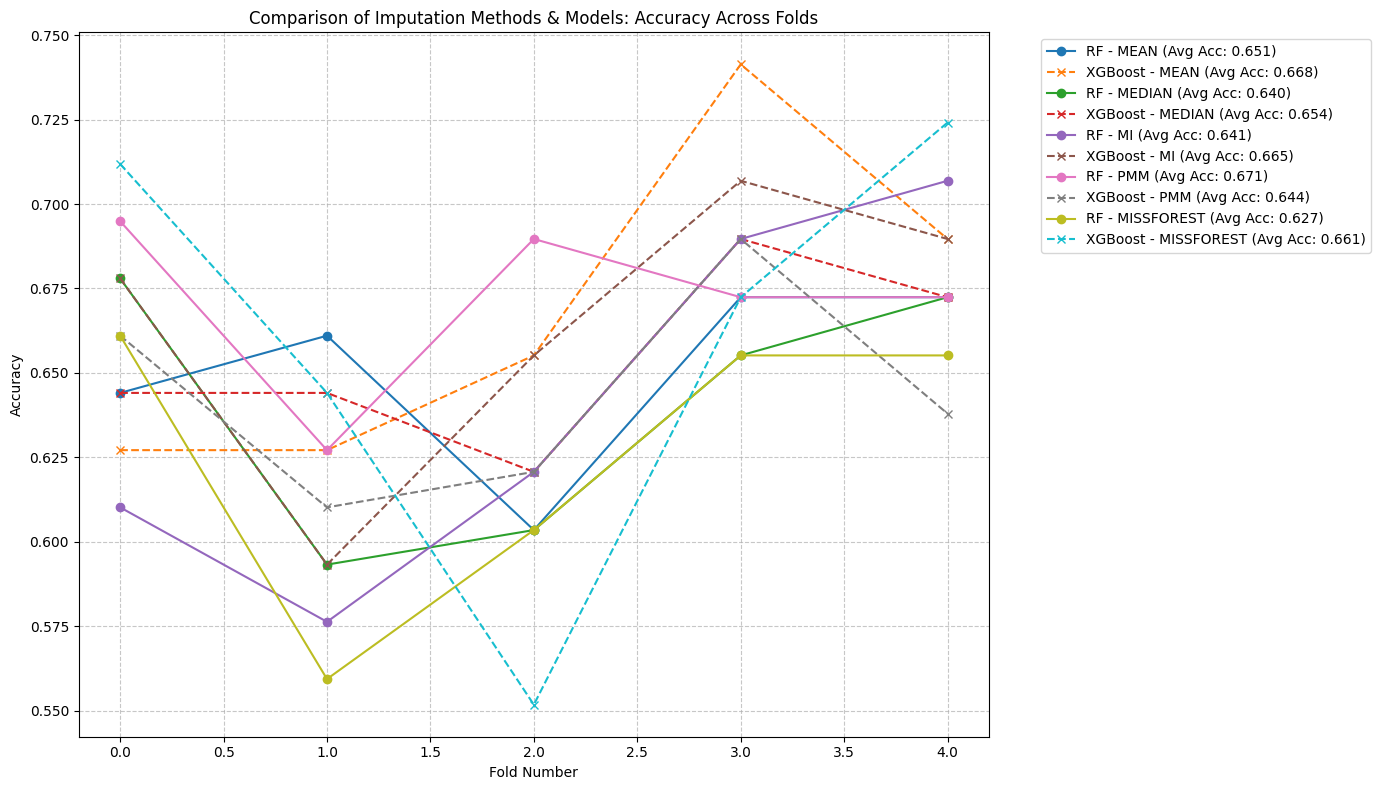

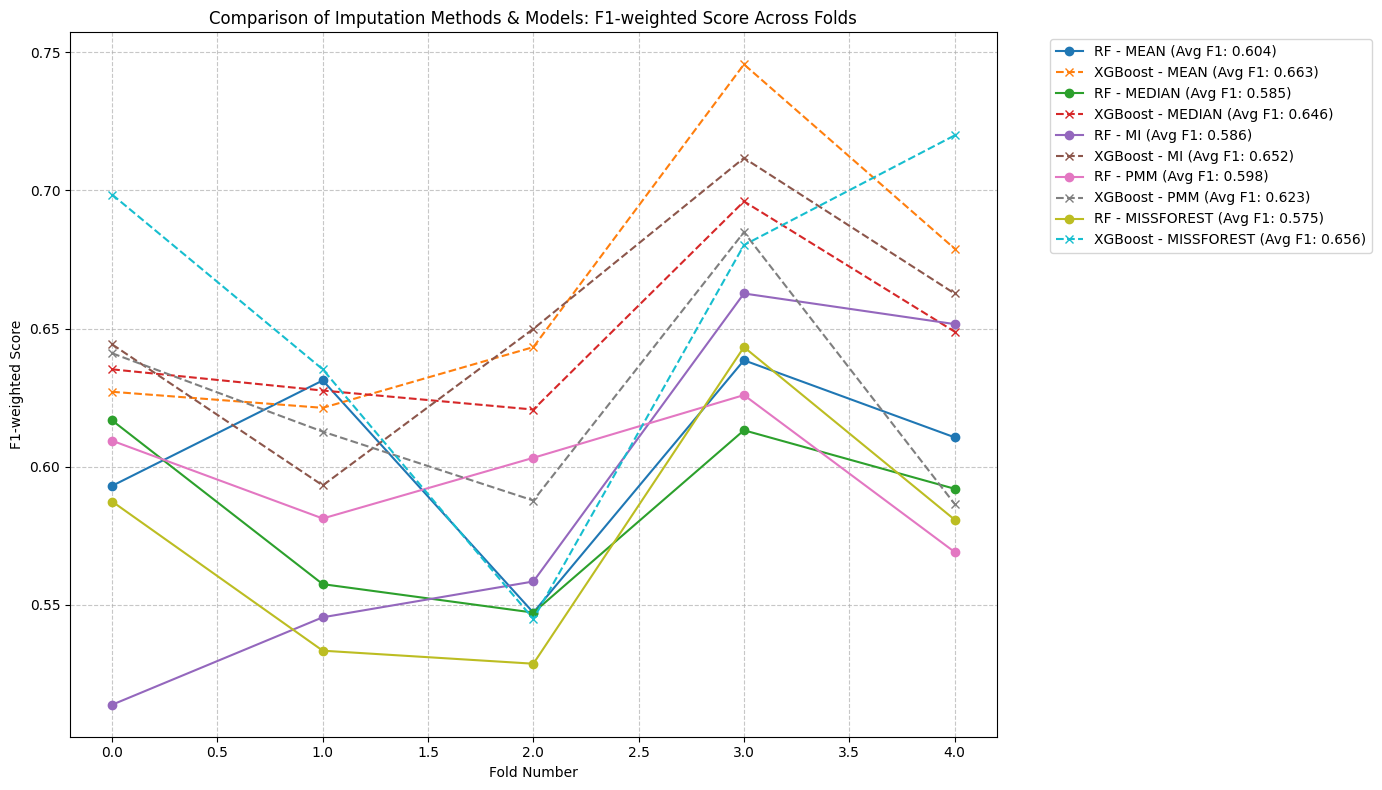


--- SHAP Plots for Best RF and XGBoost Models ---
Best RF: MEAN (F1: 0.6041) | Best XGBoost: MEAN (F1: 0.6633)

SHAP Summary Plot for Random Forest (MEAN Imputation):


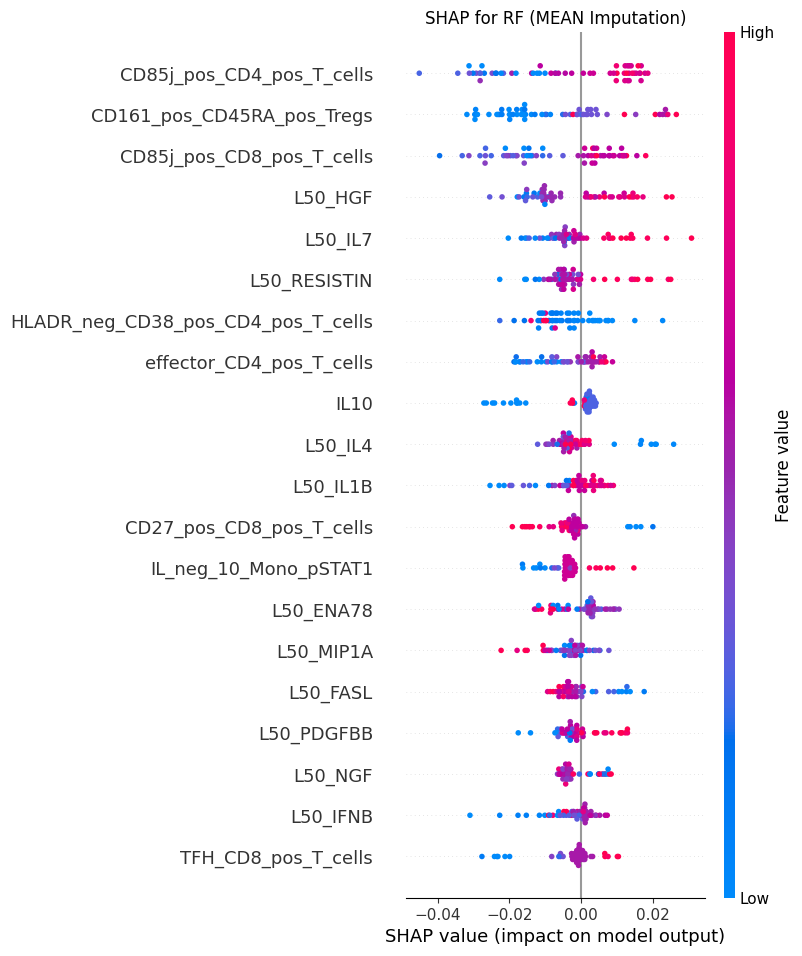


SHAP Summary Plot for XGBoost (MEAN Imputation):


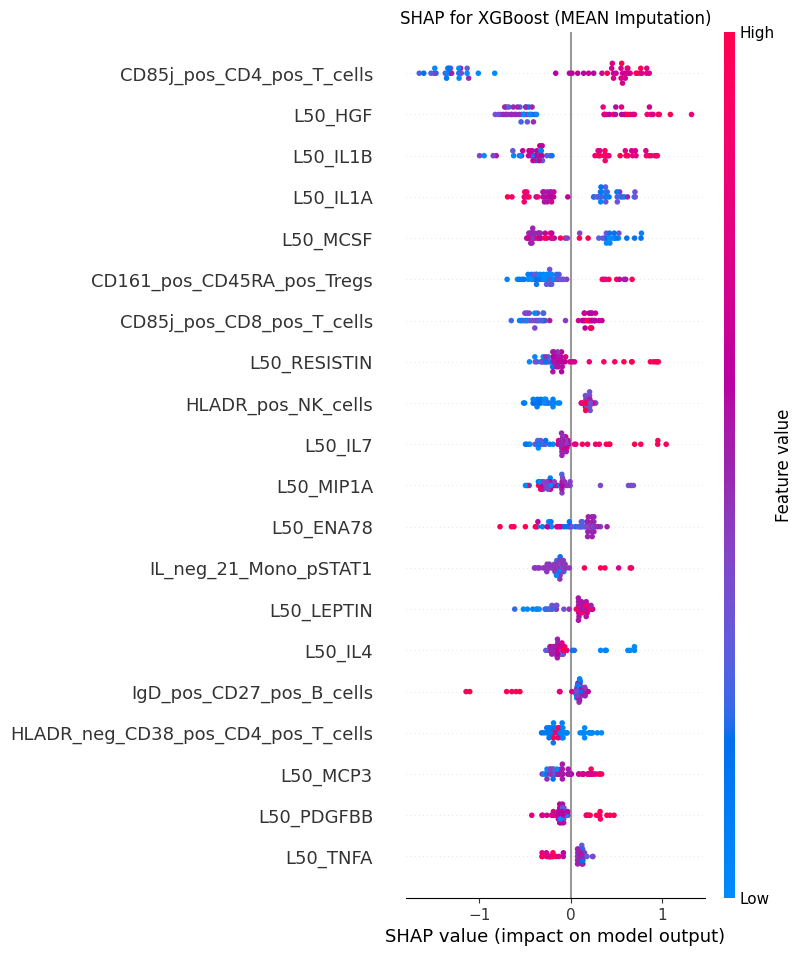

In [ ]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines for each strategy, incorporating class-imbalance handling ---
pipelines = {
    'mean_rf': Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()),
                         ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))]),
    'mean_xgb': Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()),
                          ('classifier', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1))]),
    'median_rf': Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler()),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))]),
    'median_xgb': Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler()),
                            ('classifier', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1))]),
    'mi_rf': Pipeline([('imputer', IterativeImputer(random_state=42, max_iter=10, initial_strategy='mean')), ('scaler', StandardScaler()),
                       ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))]),
    'mi_xgb': Pipeline([('imputer', IterativeImputer(random_state=42, max_iter=10, initial_strategy='mean')), ('scaler', StandardScaler()),
                        ('classifier', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1))]),
    'pmm_rf': Pipeline([('imputer', IterativeImputer(random_state=42, sample_posterior=True, max_iter=10, initial_strategy='mean')), ('scaler', StandardScaler()),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))]),
    'pmm_xgb': Pipeline([('imputer', IterativeImputer(random_state=42, sample_posterior=True, max_iter=10, initial_strategy='mean')), ('scaler', StandardScaler()),
                         ('classifier', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1))]),
    'missforest_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42), random_state=42, max_iter=10)), ('scaler', StandardScaler()),
                         ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))]),
    'missforest_xgb': Pipeline([('imputer', IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42), random_state=42, max_iter=10)), ('scaler', StandardScaler()),
                         ('classifier', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1))]),
}

# Dictionary to store results
results = {
    'mean': {'rf_accuracies': [], 'xgb_accuracies': [], 'rf_f1_weighted': [], 'xgb_f1_weighted': []},
    'median': {'rf_accuracies': [], 'xgb_accuracies': [], 'rf_f1_weighted': [], 'xgb_f1_weighted': []},
    'mi': {'rf_accuracies': [], 'xgb_accuracies': [], 'rf_f1_weighted': [], 'xgb_f1_weighted': []},
    'pmm': {'rf_accuracies': [], 'xgb_accuracies': [], 'rf_f1_weighted': [], 'xgb_f1_weighted': []},
    'missforest': {'rf_accuracies': [], 'xgb_accuracies': [], 'rf_f1_weighted': [], 'xgb_f1_weighted': []},
}

# Track best models by weighted F1-score
best_rf_f1_score = -1
best_rf_strategy = ""
best_xgb_f1_score = -1
best_xgb_strategy = ""
best_rf_shap_data = {'X_test': None, 'rf_values': None}
best_xgb_shap_data = {'X_test': None, 'xgb_values': None}


# Function to run the pipeline for a single fold
def run_fold(pipeline, X_train, X_test, y_train, y_test, is_last_fold, strategy_name, model_name, is_best_rf, is_best_xgb):
    if model_name == 'xgb':
        class_counts = y_train.value_counts()
        count_class_0 = class_counts.get(0, 0)
        count_class_1 = class_counts.get(1, 0)
        scale_pos_weight_value = count_class_0 / count_class_1 if count_class_1 != 0 else 1
        pipeline.set_params(classifier__scale_pos_weight=scale_pos_weight_value)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    shap_data = None
    if is_last_fold and (is_best_rf or is_best_xgb):
        model = pipeline.named_steps['classifier']
        preprocessed_X_test = pipeline[:-1].transform(X_test)
        
        if isinstance(model, RandomForestClassifier) and is_best_rf:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(preprocessed_X_test)
            shap_data = {'X_test': preprocessed_X_test, 'rf_values': shap_values}
        elif isinstance(model, XGBClassifier) and is_best_xgb:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(preprocessed_X_test)
            shap_data = {'X_test': preprocessed_X_test, 'xgb_values': shap_values}
    
    return accuracy, f1_weighted, shap_data


for strategy_key, pipeline in pipelines.items():
    strategy_name = strategy_key.split('_')[0]
    model_name = strategy_key.split('_')[1]
    
    is_best_rf = False
    is_best_xgb = False
    
    print(f"\n--- Strategy: {strategy_name.upper()} with Model: {model_name.upper()} ---")

    fold_results = Parallel(n_jobs=-1)(
        delayed(run_fold)(
            pipeline,
            X_filtered.iloc[train_index],
            X_filtered.iloc[test_index],
            y.iloc[train_index],
            y.iloc[test_index],
            fold == n_splits - 1,
            strategy_name,
            model_name,
            is_best_rf,
            is_best_xgb
        )
        for fold, (train_index, test_index) in enumerate(skf.split(X_filtered, y))
    )
    
    accuracies = [res[0] for res in fold_results]
    f1_scores = [res[1] for res in fold_results]
    
    results[strategy_name][f'{model_name}_accuracies'] = accuracies
    results[strategy_name][f'{model_name}_f1_weighted'] = f1_scores
    
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracies)
    std_f1 = np.std(f1_scores)
    std_accuracy = np.std(accuracies)
    
    print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Average F1-weighted: {avg_f1:.4f} ± {std_f1:.4f}")
    
    # Check if this is the best performing model for its type so far
    if model_name == 'rf' and avg_f1 > best_rf_f1_score:
        best_rf_f1_score = avg_f1
        best_rf_strategy = strategy_name
    elif model_name == 'xgb' and avg_f1 > best_xgb_f1_score:
        best_xgb_f1_score = avg_f1
        best_xgb_strategy = strategy_name
    
    del fold_results

# Now, re-run the final fold for the best models to collect SHAP values
print(f"\n--- Re-running the final fold for the best RF and XGBoost models to collect SHAP values ---")

# Identify the pipelines for the best RF and XGBoost models
best_rf_pipeline_key = f'{best_rf_strategy}_rf'
best_rf_pipeline = pipelines[best_rf_pipeline_key]
best_xgb_pipeline_key = f'{best_xgb_strategy}_xgb'
best_xgb_pipeline = pipelines[best_xgb_pipeline_key]

# Get the data for the final fold
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# Run fold for best RF model
_, _, rf_shap_data = run_fold(best_rf_pipeline, X_train_final, X_test_final, y_train_final, y_test_final, True, best_rf_strategy, 'rf', True, False)
if rf_shap_data:
    best_rf_shap_data = rf_shap_data

# Run fold for best XGBoost model
_, _, xgb_shap_data = run_fold(best_xgb_pipeline, X_train_final, X_test_final, y_train_final, y_test_final, True, best_xgb_strategy, 'xgb', False, True)
if xgb_shap_data:
    best_xgb_shap_data = xgb_shap_data

print("\n" + "="*40)
print("--- Cross-Validation Summary (with Imbalance Handling) ---")
print("="*40)

for strategy, model_results in results.items():
    print(f"\n--- Imputation Method: {strategy.upper()} ---")
    print(f"  Random Forest Average Accuracy: {np.mean(model_results['rf_accuracies']):.4f} ± {np.std(model_results['rf_accuracies']):.4f}")
    print(f"  Random Forest Average F1-weighted: {np.mean(model_results['rf_f1_weighted']):.4f} ± {np.std(model_results['rf_f1_weighted']):.4f}")
    print(f"  XGBoost Average Accuracy: {np.mean(model_results['xgb_accuracies']):.4f} ± {np.std(model_results['xgb_accuracies']):.4f}")
    print(f"  XGBoost Average F1-weighted: {np.mean(model_results['xgb_f1_weighted']):.4f} ± {np.std(model_results['xgb_f1_weighted']):.4f}")

# --- Plotting ---
print("\n--- Generating Comparison Plots (Accuracy & F1-weighted) ---")

# Plot 1: Accuracy Comparison
plt.figure(figsize=(14, 8))
imputation_strategies = list(results.keys())
for method in imputation_strategies:
    plt.plot(results[method]['rf_accuracies'], marker='o', linestyle='-',
             label=f'RF - {method.upper()} (Avg Acc: {np.mean(results[method]["rf_accuracies"]):.3f})')
    plt.plot(results[method]['xgb_accuracies'], marker='x', linestyle='--',
             label=f'XGBoost - {method.upper()} (Avg Acc: {np.mean(results[method]["xgb_accuracies"]):.3f})')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Comparison of Imputation Methods & Models: Accuracy Across Folds')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: F1-weighted Comparison
plt.figure(figsize=(14, 8))
for method in imputation_strategies:
    plt.plot(results[method]['rf_f1_weighted'], marker='o', linestyle='-',
             label=f'RF - {method.upper()} (Avg F1: {np.mean(results[method]["rf_f1_weighted"]):.3f})')
    plt.plot(results[method]['xgb_f1_weighted'], marker='x', linestyle='--',
             label=f'XGBoost - {method.upper()} (Avg F1: {np.mean(results[method]["xgb_f1_weighted"]):.3f})')
plt.xlabel('Fold Number')
plt.ylabel('F1-weighted Score')
plt.title('Comparison of Imputation Methods & Models: F1-weighted Score Across Folds')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- SHAP Plots ---
print("\n" + "="*40)
print(f"--- SHAP Plots for Best RF and XGBoost Models ---")
print(f"Best RF: {best_rf_strategy.upper()} (F1: {best_rf_f1_score:.4f}) | Best XGBoost: {best_xgb_strategy.upper()} (F1: {best_xgb_f1_score:.4f})")
print("="*40)


original_feature_names = X_filtered.columns

# RF SHAP plot
if best_rf_shap_data['rf_values'] is not None:
    print(f"\nSHAP Summary Plot for Random Forest ({best_rf_strategy.upper()} Imputation):")
    shap_values_rf_for_plot = best_rf_shap_data['rf_values'][:, :, 1]
    
    # Pass the original feature names directly
    shap.summary_plot(shap_values_rf_for_plot, best_rf_shap_data['X_test'], show=False, feature_names=original_feature_names)
    plt.title(f"SHAP for RF ({best_rf_strategy.upper()} Imputation)")
    plt.show()
else:
    print(f"SHAP values for the best RF model ({best_rf_strategy.upper()} imputation) were not collected.")

# XGB SHAP plot
if best_xgb_shap_data['xgb_values'] is not None:
    print(f"\nSHAP Summary Plot for XGBoost ({best_xgb_strategy.upper()} Imputation):")
    shap_values_xgb = best_xgb_shap_data['xgb_values']
    if isinstance(shap_values_xgb, list) and len(shap_values_xgb) > 1:
        shap_values_xgb_for_plot = shap_values_xgb[1]
    elif isinstance(shap_values_xgb, np.ndarray) and shap_values_xgb.ndim == 3:
        shap_values_xgb_for_plot = shap_values_xgb[:, :, 1]
    else:
        shap_values_xgb_for_plot = shap_values_xgb
    
    # Pass the original feature names directly
    shap.summary_plot(shap_values_xgb_for_plot, best_xgb_shap_data['X_test'], show=False, feature_names=original_feature_names)
    plt.title(f"SHAP for XGBoost ({best_xgb_strategy.upper()} Imputation)")
    plt.show()
else:
    print(f"SHAP values for the best XGBoost model ({best_xgb_strategy.upper()} imputation) were not collected.")

## Step 3: Confusion Matrices, ROC-AUC and logloss calculations for Best Mean-Imputation Models
As in the previous ML models we visualise **confusion matrices**, the **ROC-AUC curves** and calculate the **log-loss** for the best-performing Random Forest and XGBoost models. This gives us a great visual summary of how well our models are doing.

--- Training and Evaluating Random Forest (Mean Imputation) ---


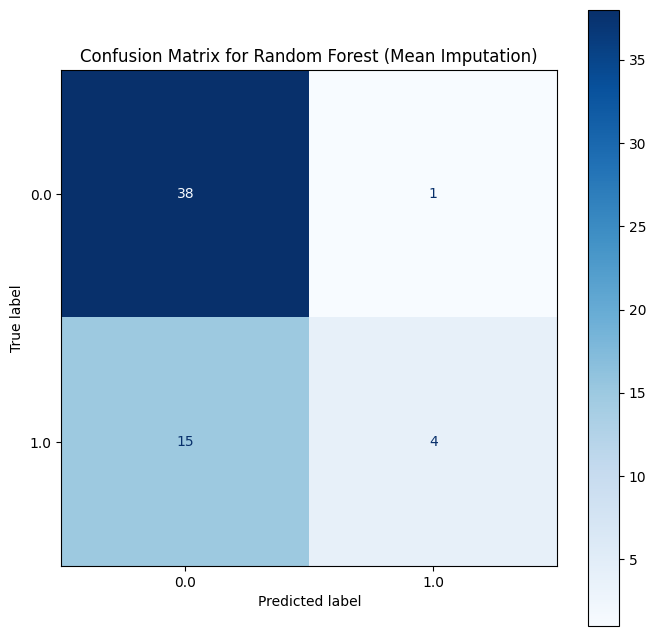



--- Training and Evaluating XGBoost (Mean Imputation) ---


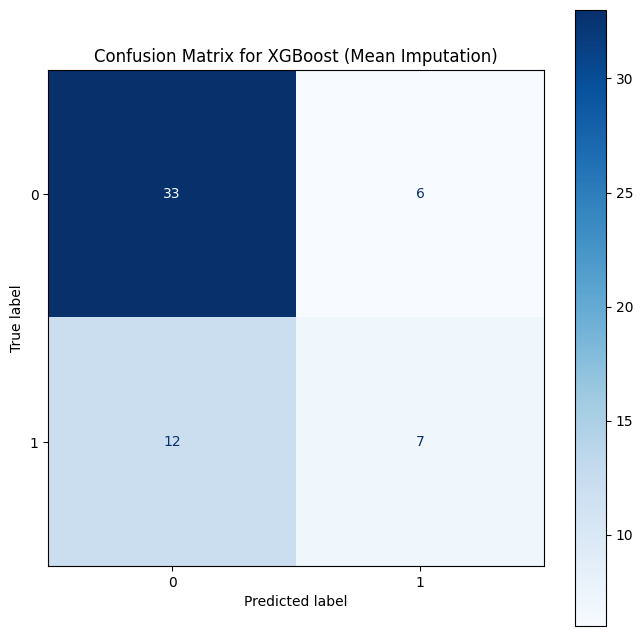

In [9]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines for the Mean Imputation Models ---
mean_pipelines = {
    'mean_rf': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    'mean_xgb': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1))
    ])
}

# Get the data for the final fold (last fold of the cross-validation)
# This ensures consistency with the SHAP plots from the original run.
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# --- Train and Evaluate the RF Mean Model ---
print("--- Training and Evaluating Random Forest (Mean Imputation) ---")
rf_mean_pipeline = mean_pipelines['mean_rf']
rf_mean_pipeline.fit(X_train_final, y_train_final)
y_pred_rf = rf_mean_pipeline.predict(X_test_final)

# Create and plot the Confusion Matrix for RF
cm_rf = confusion_matrix(y_test_final, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_mean_pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for Random Forest (Mean Imputation)")
plt.show()

print("\n")

# --- Train and Evaluate the XGBoost Mean Model ---
print("--- Training and Evaluating XGBoost (Mean Imputation) ---")
xgb_mean_pipeline = mean_pipelines['mean_xgb']
xgb_mean_pipeline.fit(X_train_final, y_train_final)
y_pred_xgb = xgb_mean_pipeline.predict(X_test_final)

# Create and plot the Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test_final, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_mean_pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for XGBoost (Mean Imputation)")
plt.show()

## ROC and AUC

--- Evaluating Random Forest (Mean Imputation) ---
Random Forest Mean AUC: 0.6869
--- Evaluating XGBoost (Mean Imputation) ---
XGBoost Mean AUC: 0.6802


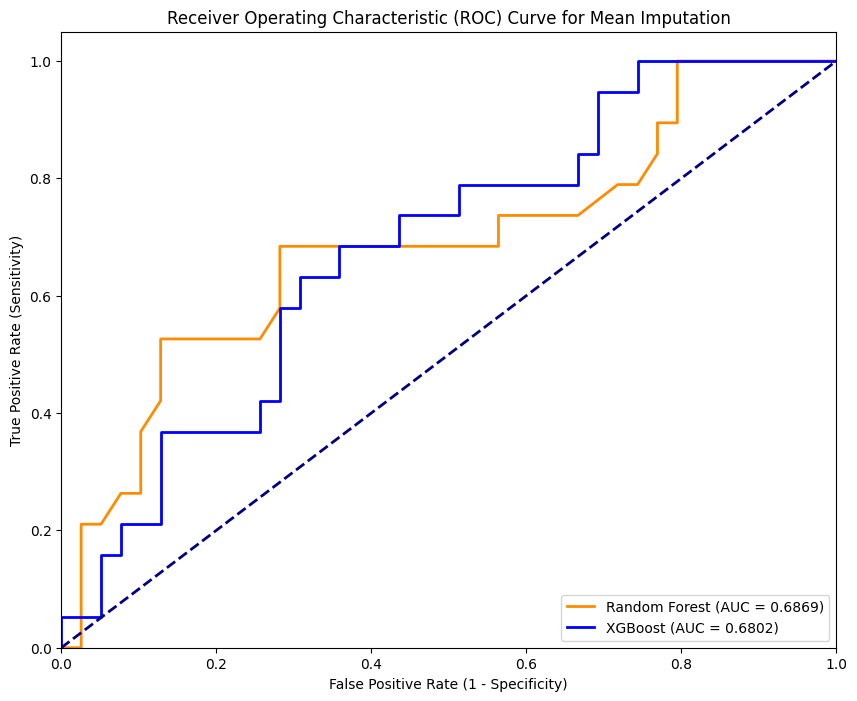

In [10]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines for the Mean Imputation Models ---
mean_pipelines = {
    'mean_rf': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    'mean_xgb': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1))
    ])
}

# Get the data for the final fold (last fold of the cross-validation)
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# --- Train and Evaluate the RF Mean Model ---
print("--- Evaluating Random Forest (Mean Imputation) ---")
rf_mean_pipeline = mean_pipelines['mean_rf']
rf_mean_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for the positive class
y_proba_rf_mean = rf_mean_pipeline.predict_proba(X_test_final)[:, 1]

# Calculate ROC curve and AUC
fpr_rf_mean, tpr_rf_mean, _ = roc_curve(y_test_final, y_proba_rf_mean)
auc_rf_mean = roc_auc_score(y_test_final, y_proba_rf_mean)
print(f"Random Forest Mean AUC: {auc_rf_mean:.4f}")

# --- Train and Evaluate the XGBoost Mean Model ---
print("--- Evaluating XGBoost (Mean Imputation) ---")
xgb_mean_pipeline = mean_pipelines['mean_xgb']
xgb_mean_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for the positive class
y_proba_xgb_mean = xgb_mean_pipeline.predict_proba(X_test_final)[:, 1]

# Calculate ROC curve and AUC
fpr_xgb_mean, tpr_xgb_mean, _ = roc_curve(y_test_final, y_proba_xgb_mean)
auc_xgb_mean = roc_auc_score(y_test_final, y_proba_xgb_mean)
print(f"XGBoost Mean AUC: {auc_xgb_mean:.4f}")

# --- Plotting the ROC Curves ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf_mean, tpr_rf_mean, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_rf_mean:.4f})')
plt.plot(fpr_xgb_mean, tpr_xgb_mean, color='blue', lw=2, label=f'XGBoost (AUC = {auc_xgb_mean:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Mean Imputation')
plt.legend(loc='lower right')
plt.show()

## Log-loss

In [11]:
# --- Define Pipelines for the Mean Imputation Models ---
mean_pipelines = {
    'mean_rf': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    'mean_xgb': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1))
    ])
}

# Get the data for the final fold (last fold of the cross-validation)
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# --- Train and Evaluate the RF Mean Model ---
print("--- Evaluating Random Forest (Mean Imputation) ---")
rf_mean_pipeline = mean_pipelines['mean_rf']
rf_mean_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for the positive class
y_proba_rf_mean = rf_mean_pipeline.predict_proba(X_test_final)

# Calculate and print log-loss
logloss_rf_mean = log_loss(y_test_final, y_proba_rf_mean)
print(f"Random Forest Mean Log-Loss: {logloss_rf_mean:.4f}")

# --- Train and Evaluate the XGBoost Mean Model ---
print("--- Evaluating XGBoost (Mean Imputation) ---")
xgb_mean_pipeline = mean_pipelines['mean_xgb']
xgb_mean_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for the positive class
y_proba_xgb_mean = xgb_mean_pipeline.predict_proba(X_test_final)

# Calculate and print log-loss
logloss_xgb_mean = log_loss(y_test_final, y_proba_xgb_mean)
print(f"XGBoost Mean Log-Loss: {logloss_xgb_mean:.4f}")

--- Evaluating Random Forest (Mean Imputation) ---
Random Forest Mean Log-Loss: 0.6032
--- Evaluating XGBoost (Mean Imputation) ---
XGBoost Mean Log-Loss: 0.8644
